In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
from data_preparation import *


In [4]:

def create_callback(trainedModelPath,verbose=False):

    """
    quick function to create callbacks and or overwrite existing callbacks
    
    """
    
    return  [
        tf.keras.callbacks.ModelCheckpoint(
            trainedModelPath+"/best_model.h5", save_best_only=True, monitor="val_loss", verbose=verbose
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
        )
        
    ]

In [5]:
sampling_distance_x = 1
sampling_distance_y = 12
length = 100 # starting with 1m
whole_map = pd.read_csv('WholeMap_Rounds_40_to_17.csv')
map = stack_map(whole_map) # create a stacked map dataframe with columns x, y, z
map = cut_map_len(map,100,length) # cut the map to the length of the map
known_points, unknown_points = resample(map, sampling_distance_x, sampling_distance_y) # resample the map


In [6]:
print(f'len training-data = {len(known_points)}')
print(f'len validation-data = {len(unknown_points)}')
print(f'N = {len(map)}')

len training-data = 1430
len validation-data = 1300
N = 15730


In [7]:
known_points = randomsampling(map,known_points['x'].min(),known_points['x'].max(),known_points['y'].min(),known_points['y'].max(),sampling_distance_x, sampling_distance_y,unknown_points)


In [8]:
x = map.x
y = map.y
#x = map['x'].unique()#/known_points.x.max()
#y = map['y'].unique()#/known_points.y.max()

In [9]:
x = (x-min(x))/(max(x)-min(x))
y = (y-min(y))/(max(y)-min(y))


In [10]:
N = x.shape[0]
N

15730

In [11]:
num_basis = [10**2,19**2,37**2,73**2, 145**2]
type(num_basis[2])

int

In [12]:

knots_1dx = [np.linspace(0,1,int(np.sqrt(i))) for i in num_basis]
knots_1dy = [np.linspace(0,1,int(np.sqrt(i))) for i in num_basis]
##Wendland kernel
basis_size = 0
phi = np.zeros((N, sum(num_basis)))
for res in range(len(num_basis)):
    theta = 1/np.sqrt(num_basis[res])*2.5
    knots_x, knots_y = np.meshgrid(knots_1dx[res],knots_1dy[res])
    knots = np.column_stack((knots_x.flatten(),knots_y.flatten()))
    for i in range(num_basis[res]):
        d = np.linalg.norm(np.vstack((y,x)).T-knots[i,:],axis=1)/theta
        for j in range(len(d)):
            if d[j] >= 0 and d[j] <= 1:
                phi[j,i + basis_size] = (1-d[j])**6 * (35 * d[j]**2 + 18 * d[j] + 3)/3
            else:
                phi[j,i + basis_size] = 0
    basis_size = basis_size + num_basis[res]

In [13]:
phi = pd.DataFrame(phi)
phi.index=phi.index+map.index.min()
#phi.to_csv('phi.csv')
phi.head()

,0,1,2,3,4,5,6,7,8,9,...,28174,28175,28176,28177,28178,28179,28180,28181,28182,28183
156000,1.000000,0.175560,0.000029,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
156001,0.991087,0.174036,0.000028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
156002,0.965011,0.169537,0.000026,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
156003,0.923524,0.162276,0.000023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
156004,0.869083,0.152590,0.000018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
##### idx for train/val split


print(f'max phi index : {phi.index.max()}')
print(f'max known points index : {known_points.index.max()}')
print(f'max unknown points index : {unknown_points.index.max()}')
train_idx = known_points.loc[known_points.index < phi.index.max()].index
val_idx = unknown_points.iloc[unknown_points.index < phi.index.max()].index
#train_idx=train_idx[0]
#val_idx = val_idx[0]


max phi index : 171729
max known points index : 171598
max unknown points index : 170949


In [15]:
x_train = phi.loc[train_idx].to_numpy()
y_train = known_points.z.loc[train_idx].to_numpy()
x_val = phi.loc[val_idx].to_numpy()
y_val = unknown_points.z.loc[val_idx].to_numpy()

In [16]:
##normalization
maxval = np.max([np.max(y_train),np.max(y_val)])

y_train = y_train / maxval
y_val = y_val / maxval


In [17]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
import tensorflow as tf

2022-05-24 20:06:42.304969: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-24 20:06:42.304993: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [18]:
NB_START_EPOCHS = 2000
BATCH_SIZE = 100

In [19]:
# DeepKriging model for continuous data
p = phi.shape[1]
model = Sequential()
model.add(Dense(100, input_dim = p,  kernel_initializer='he_uniform', activation='relu'))
model.add(Dropout(rate=0.5))
model.add(BatchNormalization())
model.add(Dense(100, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(100, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='linear'))


2022-05-24 20:06:44.879954: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-24 20:06:44.879994: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-24 20:06:44.880052: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (thinkpad): /proc/driver/nvidia/version does not exist
2022-05-24 20:06:44.880429: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
trainedModelPath = f'trainedModels/NonRandomResapling/deepkriging/samplerate_x{sampling_distance_x}_y{sampling_distance_y}_length{length}/'

if not os.path.exists(trainedModelPath):
                            os.makedirs(trainedModelPath)
                
       

In [21]:

model.compile(optimizer='adam'
                      , loss='mse'
                      , metrics=['mse','mae'])
    
history = model.fit(x_train
                       , y_train
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(x_val, y_val)
                       , callbacks = create_callback(trainedModelPath)
                       , verbose=0)
    

2022-05-24 20:06:54.042150: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1612124800 exceeds 10% of free system memory.


KeyboardInterrupt: 

In [ ]:
pd.DataFrame(history.history)[['loss','val_loss']].val_loss.min()

0.0005736834718845785

In [ ]:
model = tf.keras.models.load_model(trainedModelPath+'/best_model.h5')

In [ ]:
maxval

-20.57993174105734

In [ ]:
prediction = model.predict(x_val) * maxval

407/407 [==============================] - 2s 3ms/step


In [ ]:
prediction = pd.DataFrame(prediction)

In [ ]:
prediction.index = val_idx

In [ ]:
pred_stacked = pd.merge(unknown_points[['x','y']], prediction,how='inner', left_index=True, right_index=True)
pred_stacked.columns = ['x','y','z']

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
vmin = np.min([pred_stacked.z.min(),unknown_points.z.min()])
vmax = np.max([pred_stacked.z.max(),unknown_points.z.max()])

Text(0.5, 1.0, 'validation data')

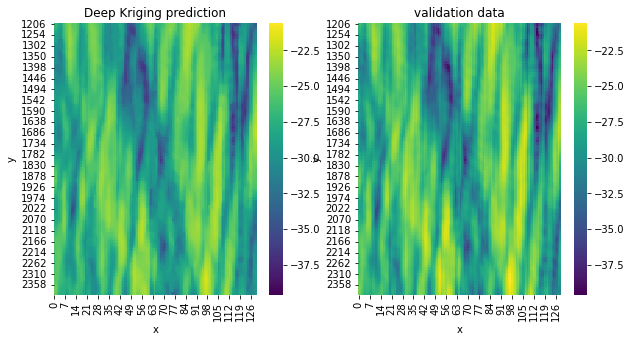

In [ ]:
plt.figure(figsize=(10,5))
ax1 = plt.subplot2grid((1,2), (0, 0))
ax2 = plt.subplot2grid((1,2), (0, 1))

sns.heatmap(ax=ax1,data=pred_stacked.pivot_table(index='y',columns='x',values='z'),vmin=vmin,vmax=vmax,cmap='viridis')
sns.heatmap(ax=ax2,data=unknown_points.loc[val_idx].pivot_table(index='y',columns='x',values='z'),vmin=vmin,vmax=vmax,cmap='viridis')
ax1.set_title('Deep Kriging prediction')
ax2.set_title('validation data')

In [ ]:
mse_phi = np.mean((pred_stacked.z - unknown_points.z.loc[val_idx])**2)#
mse_phi

0.2429742496262298

In [ ]:
from interpolation import *

In [ ]:
lin,linp = grid_interpolation(known_points, unknown_points,method='linear', verbose=False)

In [ ]:
mse_lin = np.mean((linp.z - unknown_points.z.loc[val_idx])**2)

In [ ]:
mse_lin

0.7618058718084183